# Code for generating Figure 1

## "Basic idea of our framework and a simple example"

This Python notebook contains code for generating the first figure from the paper "Gradient Descent as Loss Landscape Navigation: a Normative Framework for Deriving Learning Rules".

In [1]:
# imports
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

import torch

In [3]:
# aesthetics
lw = 4
color_darkgreen = np.array([0, 166, 81])/255
color_darkred = np.array([190, 30, 45])/255

# truncate colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'{cmap.name}_trunc',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

original_cmap = plt.get_cmap('coolwarm_r')
trunc_cmap = truncate_colormap(original_cmap, 0.1, 1)  # avoid too-bright whites

# ----------

# saving-related utility function
pic_folder = 'results/'
format_list = ['.png', '.svg', '.pdf']

def save_plot(name):
    for end in format_list:
        plt.savefig(pic_folder+name+end, bbox_inches='tight', transparent=True)
    return

<center>
<img src="fig_images/fig1-overview.png" width="1000"/></center>

**Caption.** (a) Single-step approaches (top) optimize over short-term changes to the loss, while a multi-step approach (bottom) optimizes over longer-term changes. (b) Gradient descent vs multi-step optimization for a double-well loss, with the optimal multi-step trajectory computed by directly minimizing the objective (see Appendix B for details). Note that the multi-step rule converges to the global rather than local minimum. (c) Values of the kinetic (top) and potential (bottom) terms along the optimal trajectory from (b). The loss/potential does not decrease monotonically, since the learner must first escape a local minimum.

## a. Schematic: single-step vs multi-step optimization

Visualize a double-well loss in 3D. This code only generates the surface; it does not generate the arrows or stick figures.

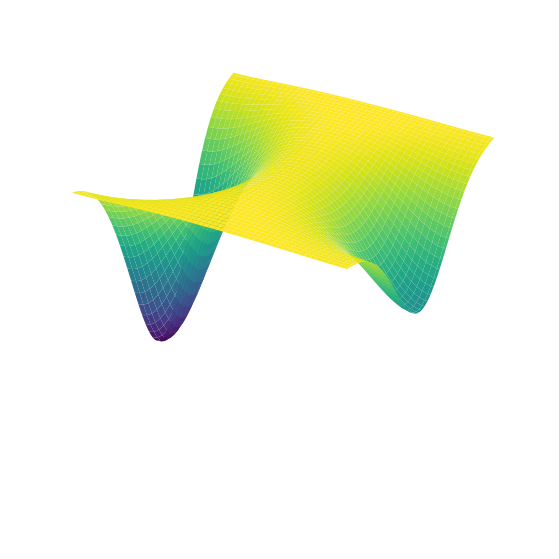

In [5]:
# define grid
x = np.linspace(-2, 2, 100); y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

# define double-well surface on the grid
Z = -np.exp(-((X + 2)**2 + (Y)**2)) - 0.5*np.exp(-((X - 2)**2 + (Y)**2))

# plot 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.axis('off')

# save, show
save_plot('3D_surface')
plt.show()

## b, c. One-step vs multi-step optimal trajectory for a double-well loss

Compute optimal learning trajectory for double-well loss by directly optimizing our objective (see Eq. 2, Sec. 2).

In [7]:
# USEFUL FUNCTIONS: OPTIMAL TRAJECTORY COMPUTATION
# see here for inspiration for this code/idea: https://github.com/greydanus/ncf

# compute least action path via direct optimization
def get_LAP(z_0, z_f, num_time_pts, t_span, L, params, steps=1000, step_size=1e-1, num_prints=8, num_stashes=80):
    t_min, t_max = t_span
    t = torch.linspace(t_min, t_max, num_time_pts); t_ = np.linspace(t_min, t_max, num_time_pts)

    x = z_0[None,:]*(1 - (t[:,None] - t_min)/(t_max - t_min) ) + ( (t[:,None] - t_min)/(t_max - t_min) )*z_f[None,:]
    x.requires_grad = True
     
    print_on = np.linspace(0,int(np.sqrt(steps)),num_prints).astype(np.int32)**2 # print more often early in loop

    for i in range(steps):
        grad_x = torch.autograd.grad(action(x, t, L, params), x)[0]
        grad_x[[0,-1]] *= 0  # fix first and last coordinates by zeroing their grads
        x.data -= grad_x * step_size

        if i in print_on: print('step={:04d}, S={:.4e}'.format(i, action(x, t, L, params).item()))
    return t_, x


# get action given Lagrangian by integrating
def action(x, t, L, params):
    dt = t[1]-t[0]

    xdot = (x[1:] - x[:-1]) / dt     # finite difference approx of time derivative
    L_ = L(x[:-1], xdot, t[:-1], params)  
    return L_.mean()


# loss / 'potential energy'
def V_doublewell(x, y):
    return a * (x**2 - b)**2 + c * y**2 + d * x


# full objective to numerically optimize (param change cost + loss)
def J_doublewell(z, zdot, t, params):
    a, b, c, d = params['a'], params['b'], params['c'], params['d']
    eta, k, gamma= params['eta'], params['k'], params['gamma']
    
    x_, y_ = z[:,0], z[:,1]

    V_ = a * (x_**2 - b)**2 + c * y_**2 + d * x_
    J = torch.exp(- gamma*t)*(  (1/(2*eta))*(zdot[:,0]**2 + zdot[:,1]**2) + k*V_   )
    return J

Set parameters.

In [9]:
num_steps = 50
T = 4
t_span = [0, T]

a = 1.0
b = 1.0
c = 1.0
d = -0.5
params = {'eta':1, 'k':1, 'gamma':0.1, 'a':a, 'b':b, 'c':c, 'd':d}

Numerically optimize.

In [11]:
x0, y0 = -0.6, 0.55
x_star, y_star = 1. + 1/16, 0
z_0 = torch.tensor([x0, y0]); z_f = torch.tensor([x_star, y_star])

t, z_ = get_LAP(z_0, z_f, num_steps, t_span, J_doublewell, params, steps=60000, step_size=1e-2)
z_t = z_.detach().cpu().numpy()

step=0000, S=6.3151e-01
step=1156, S=4.3173e-01
step=4761, S=2.5373e-01
step=10816, S=1.7003e-01
step=19321, S=1.6957e-01
step=30276, S=1.6957e-01
step=43681, S=1.6957e-01
step=59536, S=1.6957e-01


Get gradient descent solution.

In [14]:
def V_gradient(t, z, params):
    a, b, c, d = params['a'], params['b'], params['c'], params['d']
    x, y = z
    
    dx =  -(2*a*x*(x**2 - b) + d)
    dy =  - 2*c*y
    return dx, dy

f_ = lambda t, z : V_gradient(t, z, params)
sol = solve_ivp(f_, t_span = [0, 8], y0=[x0, y0], dense_output=True, method='RK45')

gd_x_t, gd_y_t = sol.y

Plot trajectories over heatmap.

In [17]:
# get trajectory
x_t = z_t[:,0]
y_t = z_t[:,1]

# create grid of (x, y) points
x_min, x_max = -1.5, 1.5; y_min, y_max = -1.5, 1.5
x = np.linspace(x_min, x_max, 400); y = np.linspace(y_min, y_max, 400)
X, Y = np.meshgrid(x, y)
Z = V_doublewell(X, Y)    # loss heatmap on grid

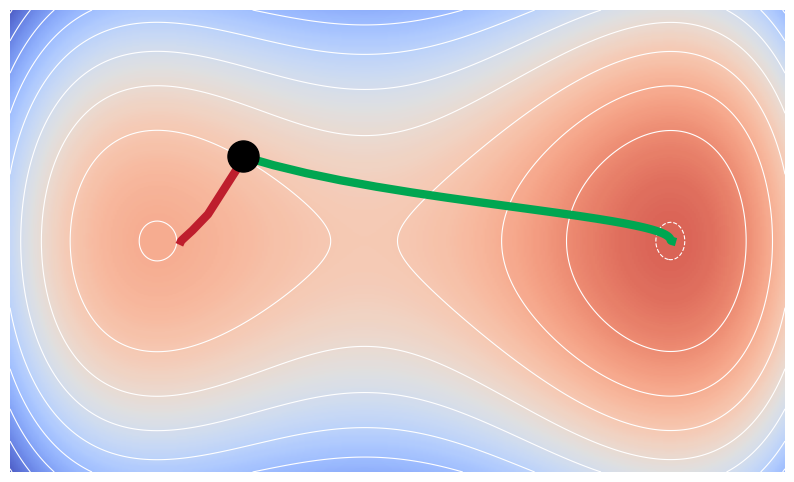

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))


# plot loss heatmap and contours
heatmap = plt.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()],
                     origin='lower', cmap=trunc_cmap, alpha=0.9, aspect='auto')
contours = plt.contour(X, Y, Z, levels=10, colors='white', linewidths=0.8)   # contour lines


# plot multi-step and gradient descent trajectories
plt.scatter(x0, y0, color='black', s=500, zorder=3)     # starting point
plt.plot(x_t, y_t, color=color_darkgreen, linewidth=6)      # optimal multi-step trajectory
plt.plot(gd_x_t, gd_y_t, color=color_darkred, linewidth=6)  # gradient descent trajectory


# save, show
ax.axis('off')
save_plot('fig1-doublewell.pdf')
plt.show()

Compute kinetic energy (i.e., parameter change cost) and potential energy (loss) along optimal multi-step trajectory.

In [25]:
# note: overall scale arbitrary and not shown in plot, so do not include learning rate or k
KE = 0.5*((np.roll(x_t,-1) - x_t)**2) + 0.5*((np.roll(y_t,-1) - y_t)**2)
KE = KE[:-1]
PE = V_doublewell(x_t, y_t)

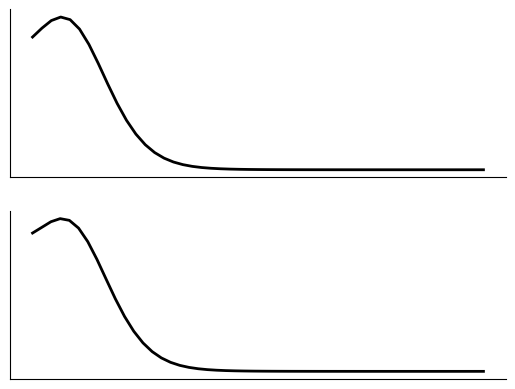

In [27]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(t[:-1], KE, color='black', linewidth=2)
ax[1].plot(t, PE, color='black', linewidth=2)

for i in range(0, 2):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
save_plot('fig1-kinetic-potential')
plt.show()